Here, I explore some heuristic methods to discover a confounding cluster.

The idea is:
- Take the top N terms for a classifier to predict y on the training data.
- Represent each term using word2vec
- Cluster the terms
- Pick the top K clusters based on correlation with y=1/y=0. Call these the *anchor clusters*.
- Represent each training and test document as a vector of cluster counts
- Compute the correlation between each cluster and the anchor clusters in training/testing data
- Score each cluster by the change in correlations from train to test

The idea is that clusters with high change are unstable, and thus likely confounds.

** The below was run on rampart. **

In [7]:
import math
import random
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from importlib import reload
import adaptive_confound.utils as acu
import adaptive_confound.control as acc
import adaptive_confound.topic_model as actm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from IPython.display import HTML, display
import astetik
import functools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pickle
import os.path
import tensorflow as tf
import itertools as it

from datetime import datetime
import gensim
from tqdm import tqdm
from sklearn import metrics, preprocessing
from sklearn.cluster import KMeans
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale
import talos
from copy import deepcopy
from scipy.stats import mode, pearsonr
from collections import Counter, defaultdict

In [3]:
# read data
ystr = 'location'
zstr = 'gender'
twitter = acu.read_pickle("/data/virgile/confound/adaptive/in/twitter_dataset_y={}_z={}.pkl".format(ystr, zstr))
twitter.create_biased_datasets(1000, np.linspace(.1,.9,9), k=1)
product_dataset = it.product(
    twitter.get_biased_datasets(kind='train'),
    twitter.get_biased_datasets(kind='test')
)
iterator = tqdm( list( enumerate( product_dataset ) ) )

  0%|          | 0/81 [00:00<?, ?it/s]                                       

In [4]:
# grab a highly biased dataset.

def get_data_with_bias(iterator, lower, upper):
    """
    get a random train/test split with bias change greater than lower and less than upper.
    """
    biased_train = biased_test = None
    for i, (d_train, d_test) in iterator:
        bias_diff = d_test.get_bias() - d_train.get_bias()
        if bias_diff > lower and bias_diff < upper:
            print('bias_diff=%.2f' % bias_diff)
            biased_train = d_train
            biased_test = d_test
            break
    return biased_train, biased_test, biased_train.features        
#biased_train, biased_test, feats = get_data_with_bias(iterator, .2, .4)
#idx2word = {i:s for i, s in enumerate(feats)}


### Method 2:

The idea is:
- Take the top N terms for a classifier to predict y on the training data.
- Represent each term using word2vec
- Cluster the terms
- Pick the top K clusters based on correlation with y=1/y=0. Call these the *anchor clusters*.
- Represent each training and test document as a vector of cluster counts
- Compute the correlation between each cluster and the anchor clusters in training/testing data
- Score each cluster by the change in correlations from train to test

The idea is that clusters with high change are unstable, and thus likely confounds.


In [5]:
def print_top_terms(clf, feats, n=10):
    print('class 1')
    for i in np.argsort(clf.coef_[0])[::-1][:n]:
        print('%20s\t%.2f' % (feats[i], clf.coef_[0][i]))
    print('class 0')
    for i in np.argsort(clf.coef_[0])[:n]:
        print('%20s\t%.2f' % (feats[i], clf.coef_[0][i]))
        
def get_signed_anova(X, y):
    """
    f_classif scores signed for pos/neg class
    assumes y \in {0,1}
    """
    y = np.array(y)
    f_scores = f_classif(X, y)[0]  
    
    pos_counts = X[np.where(y==1)].sum(axis=0).A1
    neg_counts = X[np.where(y==0)].sum(axis=0).A1
    tot_pos = X[np.where(y==1)].sum()
    tot_neg = X[np.where(y==0)].sum()
    print('totpos=%d tptneg=%d' % (tot_pos, tot_neg))
    print('pos_counts: %s' % str(pos_counts[:10]))
    print('neg_counts: %s' % str(neg_counts[:10]))
    print('pos_probs: %s' % str((pos_counts/tot_pos)[:10]))
    print('neg_probs: %s' % str((neg_counts/tot_neg)[:10]))
    word_counts = X.sum(axis=0).A1
    diffs = pos_counts/tot_pos - neg_counts/tot_neg
    signs = np.array([1 if i >0 else -1 for i in diffs])
    print(Counter(signs))
    return f_scores * signs

def get_correls(X, y):
    """
    correlations of X and y
    """
    y = np.array(y)
    X = X.toarray()
    return np.array([pearsonr(X[:,i], y)[0] for i in range(X.shape[1])])

"""
Compute change in correlation (or mutual information) between two features from train to test.
"""
def train_test_corr_diff(termi, termj, X_train, X_test):
    return abs(pearsonr(X_train[:,termi].toarray(), X_train[:,termj].toarray())[0] - 
               pearsonr(X_test[:,termi].toarray(), X_test[:,termj].toarray())[0])[0]

def train_test_mi_diff(termi, termj, X_train, X_test):
    return abs(metrics.adjusted_mutual_info_score(X_train[:,termi].toarray().flatten(),
                                                  X_train[:,termj].toarray().flatten()) -
               metrics.adjusted_mutual_info_score(X_test[:,termi].toarray().flatten(),
                                                  X_test[:,termj].toarray().flatten()))

def train_test_anchor_diff(pos_feats, neg_feats, X_train_og, X_test_og, cluster_terms):
    """
    difference in difference in correlation between correlation with pos feats and neg feats.
    """

    y_pos = X_train_og[:,pos_feats].sum(axis=1).A1
    y_neg = X_train_og[:,neg_feats].sum(axis=1).A1
    y_pos2 = X_test_og[:,pos_feats].sum(axis=1).A1
    y_neg2 = X_test_og[:,neg_feats].sum(axis=1).A1

    # remove anchor features from training.
    todrop = np.concatenate((pos_feats, neg_feats))
    X_train = X_train_og.copy()
    X_train[:,todrop] = 0
    X_test = X_test_og.copy()
    X_test[:,todrop] = 0

    # fit classifiers to predict anchor features.
    #clf = LogisticRegression(C=1)
    #clf.fit(X_train, y_pos)
    #pos_coef = clf.coef_[0]
    #pos_coef = get_signed_anova(X_train, y_pos)
    pos_coef = get_correls(X_train, y_pos)
    #clf.fit(X_train, y_neg)
    #neg_coef = clf.coef_[0]
    #neg_coef = get_signed_anova(X_train, y_neg)
    neg_coef = get_correls(X_train, y_neg)

    coef_diff = pos_coef - neg_coef

    #clf.fit(X_test, y_pos2)
    #pos_coef2 = clf.coef_[0]
    #pos_coef2 = get_signed_anova(X_test, y_pos2)
    pos_coef2 = get_correls(X_test, y_pos2)

    #clf.fit(X_test, y_neg2)
    #neg_coef2 = clf.coef_[0]
    #neg_coef2 = get_signed_anova(X_test, y_neg2)
    neg_coef2 = get_correls(X_test, y_neg2)

    
    coef_diff2 = np.abs(coef_diff - (pos_coef2 - neg_coef2))
    ###coef_diff2 = np.abs(pos_coef - pos_coef2)
    # zero out anchor features
    coef_diff2[np.concatenate((pos_feats, neg_feats))] = 0
    for i in np.argsort(coef_diff2)[::-1][:100]:
        print('cid=%d score=%.2f train_pos=%.2f train_neg=%.2f test_pos=%.2f test_neg=%.2f' %
               (i, coef_diff2[i], pos_coef[i], neg_coef[i], pos_coef2[i], neg_coef2[i]))
        print(' '.join(cluster_terms[i][:10]))
        print()
    return coef_diff2

def eval_confound_finder(cluster_scores, X, z):
    """
    sort cluster scores in descending order.
    plot the correlation between each cluster and z.
    """
    true_correls = np.abs(get_correls(X, z))
    ids = []
    means = []
    for i in np.argsort(cluster_scores)[::-1]:
        ids.append(i)
        means.append(true_correls[ids].mean())

    ub_means = []
    ub_ids = []
    for i in np.argsort(true_correls)[::-1]:
        ub_ids.append(i)
        ub_means.append(true_correls[ub_ids].mean())

    plt.figure()
    #plt.plot(means, 'b-')
    #plt.plot(ub_means, 'g-', label='ub')
    plt.plot(true_correls[ids], 'b.', label='pred')
    plt.plot(sorted(true_correls)[::-1], 'g.', label='ub')
    plt.ylabel('correlation with z')
    plt.xlabel('rank')
    plt.legend()
    plt.show()
    
    
# cluster top n words 
def cluster_words(indices, feats, w2v, n_clusters):
    indices = [i for i in indices if feats[i] in w2v]
    words = np.array(feats[indices])
    vecs = [w2v[w] for w in words]
    kmeans = KMeans(n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(vecs)
    print('biggest clusters:', Counter(cluster_labels).most_common(10))
    wordi2cluster = {i:c for i,c in zip(indices, cluster_labels)}
    return wordi2cluster

def print_clusters(wordi2cluster, feats, n=5):
    cluster2words = defaultdict(list)
    for wi,ci in wordi2cluster.items():
        cluster2words[ci].append(wi)
    for ci,wordis in sorted(cluster2words.items()):
        print('%d\t%s' % (ci, '  '.join(feats[wordis][:n])))

def words2clusters(X, wordi2cluster, n_clusters):
    """ convert word feature vector to cluster feature vector."""
    feats = np.zeros((X.shape[0], n_clusters))
    count = 0
    for i, xi in enumerate(X):        
        for j in xi.nonzero()[1]:
            if j in wordi2cluster:
                feats[i, wordi2cluster[j]] += 1
    return sp.csr_matrix(feats)

def get_cluster_terms(wordi2cluster, feats):
    cluster2words = defaultdict(list)
    for wi,ci in wordi2cluster.items():
        cluster2words[ci].append(feats[wi])
    return cluster2words

def print_top_terms_by_correl(X, y, cluster_features, n=5):
    correls = get_correls(X, y)
    print('pos correl:')
    for ci in np.argsort(correls)[::-1][:n]:
        print('%d: %s' % (ci, ' '.join(cluster_features[ci][:5])))
    print('neg correl:')
    for ci in np.argsort(correls)[:n]:
        print('%d: %s' % (ci, ' '.join(cluster_features[ci][:5])))

In [ ]:
"""
load w2v
"""
w2v = gensim.models.KeyedVectors.load_word2vec_format("/data/culotta/twitter_w2v/tw_w2v.bin", binary=True) 

In [ ]:
# DO METHOD 2
biased_train, biased_test, feats = get_data_with_bias(iterator, .6, .7)
topn = 1000
n_clusters = 100
#topn = 200
#n_clusters = 50


# fit on X on y
clf = LogisticRegression(C=1)
clf.fit(biased_train.X, biased_train.y)
print('top y features')
print_top_terms(clf, feats, n=5)
print('word features, test y acc=%.3f' % metrics.accuracy_score(clf.predict(biased_test.X), biased_test.y))

# cluster positive terms
wordi2cluster = cluster_words(np.argsort(clf.coef_[0])[:topn], feats, w2v, int(n_clusters/2))
wordi2cluster2 = cluster_words(np.argsort(clf.coef_[0])[::-1][:topn], feats, w2v, int(n_clusters/2))
for k,v in wordi2cluster2.items():
    wordi2cluster[k] = v+int(n_clusters/2)
    
    
print_clusters(wordi2cluster, feats)
cluster_terms = get_cluster_terms(wordi2cluster, feats)
    
#X_train_cluster = sp.csr_matrix(scale(words2clusters(biased_train.X, wordi2cluster, n_clusters).todense()))
#X_test_cluster = sp.csr_matrix(scale(words2clusters(biased_test.X, wordi2cluster, n_clusters).todense()))
X_train_cluster = words2clusters(biased_train.X, wordi2cluster, n_clusters)
X_test_cluster = words2clusters(biased_test.X, wordi2cluster, n_clusters)

# classify z based on cluster features
clf = LogisticRegression(C=1)
clf.fit(X_train_cluster, biased_train.z)
print('top z cluster features')
print_top_terms(clf, np.arange(n_clusters), n=5)
print('cluster features, test z acc=%.3f' % metrics.accuracy_score(clf.predict(X_test_cluster), biased_test.z))
print_top_terms_by_correl(X_train_cluster, biased_train.z, cluster_terms)

# classify y based on cluster features
clf = LogisticRegression(C=.01)
clf.fit(X_train_cluster, biased_train.y)
print('top y cluster features')
print_top_terms(clf, np.arange(n_clusters), n=5)
print('cluster features, test y acc=%.3f' % metrics.accuracy_score(clf.predict(X_test_cluster), biased_test.y))
print_top_terms_by_correl(X_train_cluster, biased_train.y, cluster_terms)


# method 2: score each cluster by correlation with each class label.
# sort clusters by how their similarity with these "good" clusters changes from train
# to test.
n_anchors = 1
neg_anchors = np.argsort(clf.coef_[0])[:n_anchors]
pos_anchors = np.argsort(clf.coef_[0])[::-1][:n_anchors]
print('pos anchors=%s, neg_anchors=%s' % (str(pos_anchors), str(neg_anchors)))
scores = train_test_anchor_diff(pos_anchors, neg_anchors, X_train_cluster, X_test_cluster, cluster_terms)

eval_confound_finder(scores, X_test_cluster, biased_test.z)

In [ ]:
# score distribution
plt.figure()
plt.plot(sorted(scores)[::-1])
plt.ylabel('confound score')
plt.xlabel('rank')
plt.show()

This method identifies the top clusters as confounds as:

```
cid=88 score=0.31 train_pos=0.49 train_neg=0.27 test_pos=0.32 test_neg=0.41
xo cutie bff xoxo babe mami princess bestie yas honey

cid=57 score=0.28 train_pos=0.58 train_neg=0.39 test_pos=0.41 test_neg=0.49
cute sexy gorgeous basic handsome fab rockin fave chic sassy

cid=75 score=0.21 train_pos=0.64 train_neg=0.40 test_pos=0.53 test_neg=0.50
makeup jersey bodies boots skin clothes dress bracelet scent bag

cid=41 score=0.20 train_pos=0.29 train_neg=0.44 test_pos=0.44 test_neg=0.39
sony sd itunes ios pe halo gta minecraft monopoly playstation

cid=74 score=0.20 train_pos=0.53 train_neg=0.32 test_pos=0.46 test_neg=0.46
excited obsessed addicted pumped proud upset emotional uncomfortable stressed convinced

cid=67 score=0.20 train_pos=0.58 train_neg=0.39 test_pos=0.46 test_neg=0.47
mother daughter mom boyfriend sister gma mama mothers cousin mommy

cid=90 score=0.19 train_pos=0.50 train_neg=0.37 test_pos=0.39 test_neg=0.45
greatest coolest cutest hottest happiest sweetest shortest

cid=53 score=0.19 train_pos=0.35 train_neg=0.17 test_pos=0.29 test_neg=0.30
rn omg yay bc lmaoo ew ahhh od lmfaoo www
```

These appear to be well correlated with gender.


**Next steps:**

- How can we inform clustering to discover just those clusters that change wrt anchor clusters from train-test?
- Idea: First find anchor clusters, as above. Then, recluster terms, using a new objective that maximizes correlation in training and minimizes correlation in testing.
 - Objective is to maximize likelihood of anchor labels in training, but *minimize* likelihood in testing.

### METHOD 3: Fit a neural net to predict anchor topics in training and test.
### Re-use feature extraction layer, and train a net to predict y, fixing extraction layer.


In [9]:
from talos.model import early_stopper
import talos as ta
from livelossplot import PlotLossesKeras
## testing: fit a neural net to predict y
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import backend as K
from keras.constraints import maxnorm

def baseline_model_f(X_train, y_train, X_val, y_val, params, sample_weight=[]):
    """
    For some reason, need to cast to int elements of params.
    talos is somehow converting them to floats.
    """
    n_classes = int(y_train.max() + 1)
    model = Sequential()
    model.add(Dense(int(params['n_hidden']), input_shape=(X_train.shape[1],),
                    kernel_constraint=maxnorm(params['maxnorm'])))
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout']))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    if len(sample_weight)==0:
        sample_weight = np.ones(X_train.shape[0])
    history = model.fit(X_train, y_train,
                        batch_size=int(params['batch_size']),
                        epochs=int(params['epochs']),
                        verbose=0,
                        validation_data=[X_val, y_val],
                        sample_weight=sample_weight,
                        callbacks=
                                   #PlotLossesKeras(),
                                   early_stopper(int(params['epochs']), mode='strict')
                        )
    return history, model


def anchor_model_f(X_train, y_train, X_val, y_val, params):
    n_classes = y.shape[1]
    model = Sequential()
    model.add(Dense(int(params['n_hidden']), input_shape=(X_train.shape[1],),
                    kernel_constraint=maxnorm(params['maxnorm'])))
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout']))
    model.add(Dense(n_classes))
    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mean_squared_error', 'acc'])
    history = model.fit(X_train, y_train,
                        batch_size=int(params['batch_size']),
                        epochs=int(params['epochs']),
                        verbose=0,
                        validation_data=[X_val, y_val],
                        callbacks=
                            early_stopper(int(params['epochs']), mode='strict')
                        )    
    return history, model

def final_model_f(X_train, y_train, X_val, y_val, params, input_weights):
    """
    """
    n_classes = int(y_train.max() + 1)
    model = Sequential()
    #input_layer = params['input_layer']
    n_hidden = input_weights[0].shape[1]
    layer = Dense(n_hidden, weights=input_weights, kernel_constraint=maxnorm(params['maxnorm']))
    layer.trainable=False
    model.add(layer)    
    #model.add(Dense(int(params['n_hidden']), input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout']))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                        batch_size=int(params['batch_size']),
                        epochs=int(params['epochs']),
                        verbose=0,
                        validation_data=[X_val, y_val],
                        callbacks=
                                   #PlotLossesKeras(),
                                   early_stopper(int(params['epochs']), mode='strict')
                        )
    return history, model

In [14]:
def get_best_params(all_params, report, metric, ascending):
    best_params = {}
    best = report.data.sort_values(metric, ascending=ascending).ix[0]
    for k in all_params.keys():
        best_params[k] = best[k]
    return best_params


def top_topic_words(model, topici, feats, n=10):
    words = []
    xzweights = model.get_weights()[0]
    for j in np.argsort(xzweights[:,topici])[::-1][:n]:
        words.append('%s/%.3f' % (feats[j], xzweights[j,topici]))
    print('   %s' % ' '.join(words))
    
def print_top_model_weights(model, n_hidden, n_words, feats):
    xzweights = model.get_weights()[0]
    zyweights = model.get_weights()[2]

    print('top weights for y=1')
    for i in np.argsort(zyweights[:,0])[::-1][:n_hidden]:
        sys.stdout.write('%d\t%.3f\t'% (i, zyweights[i,0]))
        top_topic_words(model, i, feats, n=n_words)

    print('\ntop weights for y=0')
    for i in np.argsort(zyweights[:,0])[:n_hidden]:
        sys.stdout.write('%d\t%.3f\t'% (i, zyweights[i,0]))
        top_topic_words(model, i, feats, n=n_words)
    
def get_activations(model, layer, X_batch):
    # get latent representation for an instance.
    activate = K.function([model.layers[layer].input, K.learning_phase()], [model.layers[layer].output,])
    return activate([X_batch,0])[0]

def print_top_correlations(model, X, y, feats):
    # get top correlations between each hidden layer and label y
    activations = get_activations(model, 0, X.todense())
    corrsy = [pearsonr(activations[:,vari], y)[0] for vari in range(activations.shape[1])]
    plt.figure()
    plt.plot(sorted(corrsy))
    plt.ylabel('correlation with label')
    plt.xlabel('topic rank')
    plt.show()
    print('\n\ntop correlating topics for label=1')
    for ti in np.argsort(corrsy)[::-1][:5]:
        top_topic_words(model, ti, feats, n=5)
    print('\ntop correlating topics for label=0')
    for ti in np.argsort(corrsy)[:5]:
        top_topic_words(model, ti, feats, n=5)
        
def print_top_word_correlations(X, y, feats, n=20):
    X = X.todense()
    print(X.shape)
    print(y[:5])    
    corrsy = [pearsonr(X[:,vari].A1, y)[0] for vari in range(X.shape[1])]
    print('\n\ntop correlating topics for label=1')
    print(' '.join('%s/%.2f' % (feats[fi],corrsy[fi]) for fi in np.argsort(corrsy)[::-1][:n]))
    print('\ntop correlating topics for label=0')
    print(' '.join('%s/%.2f' % (feats[fi],corrsy[fi]) for fi in np.argsort(corrsy)[:n]))


# now, predict anchor topic values on train and test.
def get_anchor_topics(model, X, y, n):
    activations = get_activations(model, 0, X.todense())
    corrsy = [pearsonr(activations[:,vari], y)[0] for vari in range(activations.shape[1])]
    negi = np.argsort(corrsy)[:n]
    posi = np.argsort(corrsy)[::-1][:n]
    return posi, negi

def get_anchor_labels(model, anchors, X):
    activations = get_activations(model, 0, X.todense())
    return activations[:,anchors]
    #return scale(activations[:,anchors])


def train_baseline_model(x, y, parms, file_suffix):
    t = ta.Scan(x=x,
                y=y,
                model=baseline_model_f,
                search_method='linear',
                grid_downsample=1, 
                params=parms,
                dataset_name='baseline',
                experiment_no='k_%s' % file_suffix)
    report = ta.Reporting('baseline_k_%s.csv' % file_suffix)
    display(report.data)
    history, model = baseline_model_f(x, y, x[-10:], y[-10:], get_best_params(parms, report, 'val_acc', False))
    return model

def diagnose_anchors(pos_anchors, neg_anchors, anchor_labels_train, anchor_labels_test):
    print('first anchor in train:')
    print(anchor_labels_train[0])
    print('first anchor in test:')
    print(anchor_labels_test[0])
    print('max pos in train:%.6g' % anchor_labels_train[:,0].max())
    print('max pos in test:%.6g' % anchor_labels_test[:,0].max())
    print('min pos in train:%.6g' % anchor_labels_train[:,0].min())
    print('min pos in test:%.6g' % anchor_labels_test[:,0].min())
    # do distribution of anchor labels vary from train->test?
    plt.figure()
    for i, p in enumerate(pos_anchors):
        plt.plot(sorted(anchor_labels_train[:,i]), label='pos_%d_train' % i, alpha=.5)
        plt.plot(sorted(anchor_labels_test[:,i]), '--', label='pos_%d_test' % i, alpha=.5)
        print('pos_%d_train mean=%.6g pos_%d_test mean=%.6g'% (i, anchor_labels_train[:,i].mean(),
                                                               i, anchor_labels_test[:,i].mean()))
    for i, p in enumerate(neg_anchors):
        i = len(pos_anchors) + i
        plt.plot(sorted(anchor_labels_train[:,i]), label='neg_%d_train' % i, alpha=.5)
        plt.plot(sorted(anchor_labels_test[:,i]), '--', label='neg_%d_test' % i, alpha=.5)
        print('neg_%d_train mean=%.6g neg_%d_test mean=%.6g'% (i, anchor_labels_train[:,i].mean(),
                                                               i, anchor_labels_test[:,i].mean()))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def train_anchor_model(model, biased_train, biased_test, parms, file_suffix):
    pos_anchors, neg_anchors = get_anchor_topics(model, biased_train.X, biased_train.y, 1)
    print('pos_anchors=%s\nneg_anchors=%s' % (str(pos_anchors), str(neg_anchors)))
    
    anchor_labels_train = get_anchor_labels(model, np.concatenate((pos_anchors, neg_anchors)), biased_train.X)
    anchor_labels_test = get_anchor_labels(model, np.concatenate((pos_anchors, neg_anchors)), biased_test.X)
    diagnose_anchors(pos_anchors, neg_anchors, anchor_labels_train, anchor_labels_test)
    ### TO discover bad topics, flip test labels.
    ##anchor_labels_test *= -1    
    X_anchor = sp.vstack((biased_train.X, biased_test.X))
    y_anchor = np.concatenate((anchor_labels_train, anchor_labels_test))        

    ### FIXME: testing with true labels
    #y_anchor = keras.utils.to_categorical(np.concatenate((biased_train.y, biased_test.y)), 2)
    # add random noise
    #y_anchor += np.random.normal(0,.1,size=(2000,2))

    # make bad
    #y_anchor = keras.utils.to_categorical(np.concatenate((biased_train.y,
    #                                                      [1 if i==0 else 0 for i in biased_test.y])), 2)
    #print('top correlations for y=1')
    #print_top_word_correlations(X_anchor, y_anchor[:,0], feats)
    #print('top correlations for y=0')
    #print_top_word_correlations(X_anchor, y_anchor[:,1], feats)
    t = ta.Scan(x=X_anchor.todense(),
            y=y_anchor,
            model=anchor_model_f,
            search_method='linear',
            grid_downsample=1, 
            params=parms,
            dataset_name='anchor',
            experiment_no='k_%s' % file_suffix)
    report = ta.Reporting('anchor_k_%s.csv' % file_suffix, sort_key='val_mean_squared_error')
    display(report.data)
    history, anchor_model = anchor_model_f(X_anchor.todense(), y_anchor,
                                         X_anchor[-10:].todense(), y_anchor[-10:],
                                         get_best_params(parms, report, 'val_mean_squared_error', True))
    return anchor_model

def train_anchor_model2(model, biased_train, biased_test, parms, file_suffix):
    pos_anchors, neg_anchors = get_anchor_topics(model, biased_train.X, biased_train.y, 1)
    print('pos_anchors=%s\nneg_anchors=%s' % (str(pos_anchors), str(neg_anchors)))
    
    anchor_labels_train = get_anchor_labels(model, np.concatenate((pos_anchors, neg_anchors)), biased_train.X)
    anchor_labels_test = get_anchor_labels(model, np.concatenate((pos_anchors, neg_anchors)), biased_test.X)
    diagnose_anchors(pos_anchors, neg_anchors, anchor_labels_train, anchor_labels_test)
    # select X from test that are most confident
    topn = 50
    posi = np.argsort(anchor_labels_test[:,0])[::-1][:topn]
    negi = np.argsort(anchor_labels_test[:,1])[::-1][:topn]
    alli = np.concatenate((posi, negi))
    X_anchor = sp.vstack((biased_train.X, biased_test.X[alli]))
    ##
    y2 = np.array([1] * topn + [0] * topn)
    # flip sign!
    #y2 = np.array([0] * topn + [1] * topn)
    ##
    print('y2 counts', Counter(y2))
    y_anchor = keras.utils.to_categorical(np.concatenate((biased_train.y, y2)), 2)
    sample_weight_value = 1
    sample_weight = np.concatenate((np.ones(len(biased_train.y)), np.ones(len(y2))*sample_weight_value))
    # need to specify validation data manually to pass in sample_weight
    valid_frac=.2
    mask = [True if random.random() < valid_frac else False for _ in range(len(y_anchor))]
    vali = np.arange(len(y_anchor))[mask]
    traini = np.arange(len(y_anchor))[np.logical_not(mask)]
    print('%d train and %d valid indices' % (len(traini), len(vali)))
    fff = functools.partial(baseline_model_f, sample_weight=sample_weight[traini])
    t = ta.Scan(x=X_anchor.todense()[traini],
                y=y_anchor[traini],
                x_val=X_anchor.todense()[vali],
                y_val=y_anchor[vali],
                model=fff,
                search_method='linear',
                grid_downsample=1, 
                params=parms,
                dataset_name='anchor',
                experiment_no='k_%s' % file_suffix)
    report = ta.Reporting('anchor_k_%s.csv' % file_suffix)
    display(report.data)
    y_anchor_test = keras.utils.to_categorical(biased_test.y, 2)
    fff = functools.partial(baseline_model_f, sample_weight=sample_weight)
    #history, anchor_model = baseline_model_f(X_anchor.todense(), y_anchor, X_anchor[-10:], y_anchor[-10:],
    history, anchor_model = fff(X_anchor.todense(), y_anchor, biased_test.X.todense(), y_anchor_test,
                                            get_best_params(parms, report, 'val_acc', False))
    return anchor_model
    

def train_final_model(x, y, input_weights, parms_all, file_suffix):
    # final model re-uses first layer, so no need to tune that.
    parms = dict(parms_all)
    parms['n_hidden'] = [input_weights[0].shape[1]]
    fff = functools.partial(final_model_f, input_weights=input_weights)
    t = ta.Scan(x=x,
                y=y,
                model=fff, #final_model_f,
                search_method='linear',
                grid_downsample=1, 
                params=parms,
                dataset_name='final',
                experiment_no='k_%s' % file_suffix)
    report = ta.Reporting('final_k_%s.csv' % file_suffix)
    display(report.data)
    history, model = fff(x, y, x[-10:], y[-10:], get_best_params(parms, report, 'val_acc', False))
    return model

def print_model_info(model, biased_train):
    feats = biased_train.features
    display(HTML('<h3>Top weights</h2>'))
    print_top_model_weights(model, 10, 5, feats)
    display(HTML('<h3>Top correlations with Y</h2>'))
    print_top_correlations(model, biased_train.X, biased_train.y, feats)
    display(HTML('<h3>Top correlations with Z</h2>'))
    print_top_correlations(model, biased_train.X, biased_train.z, feats)

**FIXME:**

Training activations are much higher than testing activations
- add a single feature indicating if instances is from training or testing.
- this will act as an additional bias term for the anchor model
- OR, just scale activations separately for train/test? (no, this doesn't work)

Why is test acc nearly 100% when fit anchor model using true labels?


Generate biased train datasets: 100%|██████████| 9/9 [00:01<00:00,  8.96it/s]
                                                                             
Generate biased test datasets: 100%|██████████| 9/9 [00:00<00:00,  9.66it/s]
                                                                            

[0.09919028340080972, 0.2, 0.29959514170040485, 0.4, 0.5, 0.6, 0.7004048582995951, 0.8016194331983806, 0.9008097165991903]
corr diff=1.17 (-0.58 train / 0.59 test)
logreg test acc=0.76


running with params {'n_hidden': 64.0, 'batch_size': 16.0, 'epochs': 3.0, 'maxnorm': 3.0, 'dropout': 0.10000000000000001}
running with params {'n_hidden': 64.0, 'batch_size': 16.0, 'epochs': 3.0, 'maxnorm': 3.0, 'dropout': 0.10000000000000001}
1 scans will take roughly 9 seconds
Scan Finished!


,epochs,maxnorm,dropout
val_acc,,,
0.81,3.0,3.0,0.1


,epochs,maxnorm,dropout
val_acc,,,
0.81,3.0,3.0,0.1


,round_epochs,val_loss,val_acc,loss,acc,n_hidden,batch_size,epochs,maxnorm,dropout
0,3,0.43,0.81,0.281,0.926,64.0,16.0,3.0,3.0,0.1


1000/1000 [==============================] - 1s 733us/step
[0.62977414321899416, 0.72199999999999998]


top weights for y=1
8	0.302	   led/0.044 whoop/0.040 ca/0.039 rodriguez/0.036 creek/0.036
33	0.300	   mon/0.020 tall/0.020 plant/0.020 thousand/0.020 assistant/0.019
35	0.276	   freeway/0.071 ucla/0.070 angeles/0.067 tfti/0.067 calif/0.062
13	0.275	   westfield/0.022 optional/0.022 grasshopper/0.022 root/0.022 bro/0.022
30	0.273	   corazón/0.037 gsw/0.036 lbj/0.036 cielo/0.033 floydmayweather/0.033
1	0.260	   los/0.068 socal/0.065 freeway/0.065 venice/0.063 ktla/0.062
16	0.256	   octopus/0.025 tyga/0.024 kingdom/0.024 mammoth/0.024 b4/0.024
31	0.252	   dodgers/0.067 latimes/0.065 ucla/0.060 losangeles/0.056 2030/0.055
12	0.248	   peaceful/0.025 fullerton/0.024 knocking/0.024 1956/0.024 ricky/0.023
27	0.247	   laughs/0.026 remarks/0.025 buffer/0.024 toy/0.024 nike/0.024

top weights for y=0
40	-0.314	   bill/0.036 visited/0.036 mami/0.035 lindo/0.035 intros/0.035
45	-0.312	   regents/0.047 phone/0.047 yr/0.046 ny1/0.046 evaluation/0.045
0	-0.294	   song/0.035 filled/0.034 ave/0.034 seem

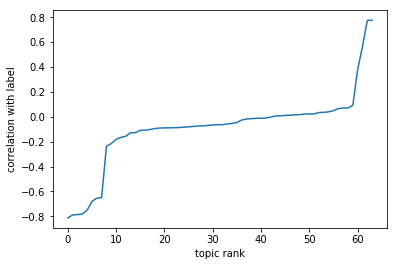



top correlating topics for label=1
   hoboken/0.063 nyc/0.063 metlife/0.059 manhattan/0.055 york/0.053
   brooklyn/0.062 ny/0.061 nypl/0.058 acquires/0.056 empirestatebuilding/0.055
   nyc/0.088 ny/0.082 snow/0.081 harvardbiz/0.077 snowing/0.077
   brushes/0.057 montauk/0.053 subtitles/0.050 shoved/0.048 knox/0.048
   lindo/0.037 bio/0.034 con/0.033 notes/0.033 comfortable/0.032

top correlating topics for label=0
   los/0.068 socal/0.065 freeway/0.065 venice/0.063 ktla/0.062
   dodgers/0.085 latimes/0.084 blvd/0.068 freeway/0.068 mammoth/0.068
   freeway/0.071 ucla/0.070 angeles/0.067 tfti/0.067 calif/0.062
   latimes/0.079 dodgers/0.071 los/0.063 angeles/0.061 malibu/0.059
   angeles/0.082 ucla/0.078 disneyland/0.076 losangeles/0.076 latimes/0.075


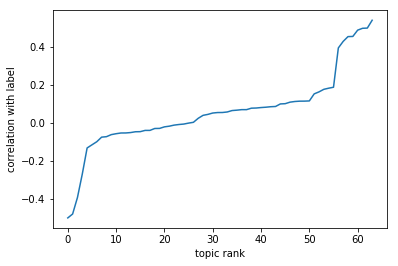



top correlating topics for label=1
   freeway/0.071 ucla/0.070 angeles/0.067 tfti/0.067 calif/0.062
   dodgers/0.085 latimes/0.084 blvd/0.068 freeway/0.068 mammoth/0.068
   los/0.068 socal/0.065 freeway/0.065 venice/0.063 ktla/0.062
   latimes/0.079 dodgers/0.071 los/0.063 angeles/0.061 malibu/0.059
   angeles/0.082 ucla/0.078 disneyland/0.076 losangeles/0.076 latimes/0.075

top correlating topics for label=0
   hoboken/0.063 nyc/0.063 metlife/0.059 manhattan/0.055 york/0.053
   brooklyn/0.062 ny/0.061 nypl/0.058 acquires/0.056 empirestatebuilding/0.055
   nyc/0.088 ny/0.082 snow/0.081 harvardbiz/0.077 snowing/0.077
   brushes/0.057 montauk/0.053 subtitles/0.050 shoved/0.048 knox/0.048
   lindo/0.037 bio/0.034 con/0.033 notes/0.033 comfortable/0.032


pos_anchors=[20]
neg_anchors=[1]
first anchor in train:
[-0.33161315  2.49282956]
first anchor in test:
[ 1.03442454  1.45478284]
max pos in train:13.4381
max pos in test:8.71411
min pos in train:-6.18197
min pos in test:-2.89077
pos_0_train mean=2.19206 pos_0_test mean=2.16389
neg_1_train mean=1.77922 neg_1_test mean=1.70364


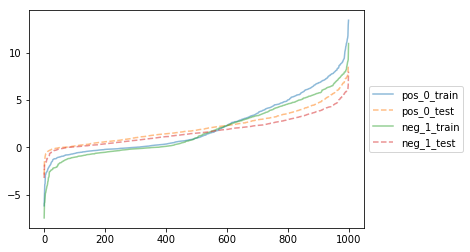

y2 counts Counter({1: 50, 0: 50})
895 train and 205 valid indices
running with params {'n_hidden': 64.0, 'batch_size': 16.0, 'epochs': 3.0, 'maxnorm': 3.0, 'dropout': 0.10000000000000001}
running with params {'n_hidden': 64.0, 'batch_size': 16.0, 'epochs': 3.0, 'maxnorm': 3.0, 'dropout': 0.10000000000000001}
1 scans will take roughly 10 seconds
Scan Finished!


,epochs,maxnorm,dropout
val_acc,,,
0.898,3.0,3.0,0.1


,epochs,maxnorm,dropout
val_acc,,,
0.898,3.0,3.0,0.1


,round_epochs,val_loss,val_acc,loss,acc,n_hidden,batch_size,epochs,maxnorm,dropout
0,3,0.313,0.898,0.07,0.998,64.0,16.0,3.0,3.0,0.1


1000/1000 [==============================] - 1s 782us/step


top weights for y=1
7	0.303	   venice/0.102 angeles/0.100 dodgers/0.092 beverly/0.088 disneyland/0.088
50	0.286	   gunna/0.025 socal/0.025 bath/0.024 bold/0.023 nailing/0.023
29	0.280	   devin/0.016 partake/0.016 slowed/0.016 kinky/0.016 richard/0.016
38	0.279	   shi/0.022 3ds/0.022 meh/0.021 rum/0.021 description/0.020
46	0.268	   unicorn/0.022 reel/0.022 comedic/0.022 heal/0.022 mi/0.022
42	0.237	   hamm/0.022 hooked/0.022 skulls/0.022 cock/0.022 feelin/0.022
1	0.223	   bra/0.064 9000/0.059 los/0.057 laid/0.055 moreno/0.053
14	0.221	   seymour/0.026 bash/0.026 pj/0.026 guard/0.025 havin/0.025
58	0.218	   deathly/0.036 felicidades/0.035 xboxone/0.034 angeles/0.034 cn/0.033
52	0.212	   reports/0.022 locations/0.022 raised/0.022 ends/0.022 satisfaction/0.022

top weights for y=0
44	-0.305	   albany/0.070 upstate/0.065 freddyamazin/0.063 greenpoint/0.060 feminist/0.059
9	-0.283	   millionaires/0.025 proposition/0.025 iconic/0.024 deepest/0.024 pos/0.024
62	-0.280	   mismo/0.036 años/0.03

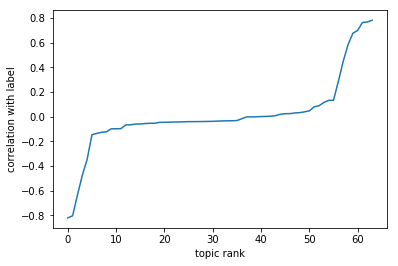



top correlating topics for label=1
   brooklyn/0.076 ny/0.070 bronx/0.069 staten/0.067 snowing/0.067
   brooklyn/0.096 staten/0.083 bronx/0.081 nyc/0.080 lic/0.078
   brooklyn/0.090 lic/0.067 nyc/0.067 bergen/0.064 broadway/0.064
   brooklyn/0.098 yankee/0.076 nj/0.076 nyc/0.074 barclays/0.073
   upstate/0.078 metrocard/0.075 preppy/0.075 thegarden/0.072 dmb/0.072

top correlating topics for label=0
   losangeles/0.087 usc/0.080 venice/0.079 weho/0.075 angeles/0.073
   venice/0.102 angeles/0.100 dodgers/0.092 beverly/0.088 disneyland/0.088
   tfti/0.063 tripinatweet/0.057 oldies/0.056 kcrw/0.055 fucken/0.055
   bra/0.064 9000/0.059 los/0.057 laid/0.055 moreno/0.053
   angeles/0.102 hollywood/0.088 los/0.085 losangeles/0.083 socal/0.081


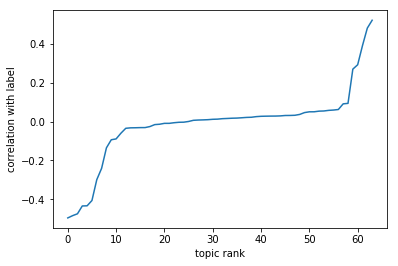



top correlating topics for label=1
   losangeles/0.087 usc/0.080 venice/0.079 weho/0.075 angeles/0.073
   venice/0.102 angeles/0.100 dodgers/0.092 beverly/0.088 disneyland/0.088
   tfti/0.063 tripinatweet/0.057 oldies/0.056 kcrw/0.055 fucken/0.055
   angeles/0.102 hollywood/0.088 los/0.085 losangeles/0.083 socal/0.081
   bra/0.064 9000/0.059 los/0.057 laid/0.055 moreno/0.053

top correlating topics for label=0
   brooklyn/0.076 ny/0.070 bronx/0.069 staten/0.067 snowing/0.067
   brooklyn/0.090 lic/0.067 nyc/0.067 bergen/0.064 broadway/0.064
   brooklyn/0.096 staten/0.083 bronx/0.081 nyc/0.080 lic/0.078
   brooklyn/0.098 yankee/0.076 nj/0.076 nyc/0.074 barclays/0.073
   upstate/0.078 metrocard/0.075 preppy/0.075 thegarden/0.072 dmb/0.072


running with params {'n_hidden': 64.0, 'batch_size': 16.0, 'epochs': 3.0, 'maxnorm': 3.0, 'dropout': 0.10000000000000001}
running with params {'n_hidden': 64.0, 'batch_size': 16.0, 'epochs': 3.0, 'maxnorm': 3.0, 'dropout': 0.10000000000000001}
1 scans will take roughly 4 seconds
Scan Finished!


,epochs,maxnorm,dropout
val_acc,,,
0.98,3.0,3.0,0.1


,epochs,maxnorm,dropout
val_acc,,,
0.98,3.0,3.0,0.1


,round_epochs,val_loss,val_acc,loss,acc,n_hidden,batch_size,epochs,maxnorm,dropout
0,3,0.249,0.98,0.366,0.889,64.0,16.0,3.0,3.0,0.1


1000/1000 [==============================] - 1s 597us/step
[0.62682049608230594, 0.69099999999999995]
['loss', 'acc']


top weights for y=1
56	0.298	   california/0.060 disneyland/0.052 ca/0.049 las/0.046 dodgers/0.046
39	0.296	   ebay/0.023 hats/0.022 greedy/0.022 meeeee/0.022 flashed/0.022
61	0.291	   126/0.022 cory/0.022 notifications/0.022 fence/0.022 wigs/0.022
21	0.284	   fuerte/0.036 toda/0.034 muchos/0.034 matata/0.033 sensual/0.032
1	0.283	   bra/0.064 9000/0.059 los/0.057 laid/0.055 moreno/0.053
35	0.243	   careful/0.024 communication/0.024 ban/0.024 gearing/0.023 statue/0.023
63	0.236	   losangeles/0.087 usc/0.080 venice/0.079 weho/0.075 angeles/0.073
27	0.218	   remembers/0.022 touched/0.022 vets/0.022 butt/0.022 inevitable/0.022
28	0.215	   launching/0.036 cuts/0.034 stores/0.033 kidcudi/0.033 platform/0.032
16	0.204	   automatically/0.025 1b/0.025 niagara/0.024 circling/0.024 rp/0.024

top weights for y=0
44	-0.325	   albany/0.070 upstate/0.065 freddyamazin/0.063 greenpoint/0.060 feminist/0.059
59	-0.313	   withdrawal/0.065 newyork/0.064 basin/0.061 311/0.061 souvenir/0.060
8	-0.281	   out

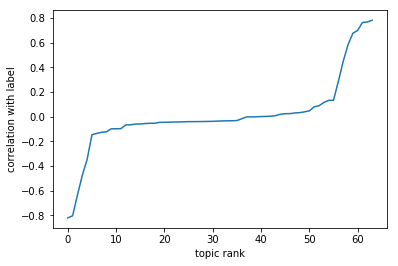



top correlating topics for label=1
   brooklyn/0.076 ny/0.070 bronx/0.069 staten/0.067 snowing/0.067
   brooklyn/0.096 staten/0.083 bronx/0.081 nyc/0.080 lic/0.078
   brooklyn/0.090 lic/0.067 nyc/0.067 bergen/0.064 broadway/0.064
   brooklyn/0.098 yankee/0.076 nj/0.076 nyc/0.074 barclays/0.073
   upstate/0.078 metrocard/0.075 preppy/0.075 thegarden/0.072 dmb/0.072

top correlating topics for label=0
   losangeles/0.087 usc/0.080 venice/0.079 weho/0.075 angeles/0.073
   venice/0.102 angeles/0.100 dodgers/0.092 beverly/0.088 disneyland/0.088
   tfti/0.063 tripinatweet/0.057 oldies/0.056 kcrw/0.055 fucken/0.055
   bra/0.064 9000/0.059 los/0.057 laid/0.055 moreno/0.053
   angeles/0.102 hollywood/0.088 los/0.085 losangeles/0.083 socal/0.081


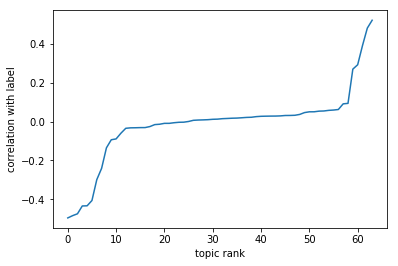



top correlating topics for label=1
   losangeles/0.087 usc/0.080 venice/0.079 weho/0.075 angeles/0.073
   venice/0.102 angeles/0.100 dodgers/0.092 beverly/0.088 disneyland/0.088
   tfti/0.063 tripinatweet/0.057 oldies/0.056 kcrw/0.055 fucken/0.055
   angeles/0.102 hollywood/0.088 los/0.085 losangeles/0.083 socal/0.081
   bra/0.064 9000/0.059 los/0.057 laid/0.055 moreno/0.053

top correlating topics for label=0
   brooklyn/0.076 ny/0.070 bronx/0.069 staten/0.067 snowing/0.067
   brooklyn/0.090 lic/0.067 nyc/0.067 bergen/0.064 broadway/0.064
   brooklyn/0.096 staten/0.083 bronx/0.081 nyc/0.080 lic/0.078
   brooklyn/0.098 yankee/0.076 nj/0.076 nyc/0.074 barclays/0.073
   upstate/0.078 metrocard/0.075 preppy/0.075 thegarden/0.072 dmb/0.072


In [17]:
# parameters
np.random.seed(42)
random.seed(42)
quick = True
train_bias = .3
test_bias = .8
parms = {
    'n_hidden': [64,128],
    'batch_size': [16,32], 
    'epochs': [20,30],
    'dropout': [0.01,.2,.3,.5],
    'maxnorm': [3,5,10,999],
}    
small_parms = {
    'n_hidden': [64], #[64, 128],
    'batch_size': [16],
    'epochs': [3], # 3
    'maxnorm': [3],  # , 10],
    'dropout': [.1], #[0.01, 0.3]
}    

# for quick training
if quick:
    parms = small_parms
    file_suffix = 'small'

# read data
twitter.create_biased_datasets(1000, np.linspace(.1,.9,9), k=1)
print([d.get_bias() for d in twitter.get_biased_datasets(kind='train')])
biased_train = [d for d in twitter.get_biased_datasets(kind='train') if abs(d.get_bias()-train_bias) < .1][0]
biased_test = [d for d in twitter.get_biased_datasets(kind='test') if abs(d.get_bias()-test_bias) < .1][0]
train_corr = pearsonr(biased_train.y, biased_train.z)[0]
test_corr = pearsonr(biased_test.y, biased_test.z)[0]
print('corr diff=%.2f (%.2f train / %.2f test)' % (test_corr-train_corr, train_corr, test_corr))

y = keras.utils.to_categorical(biased_train.y, 2)
z = keras.utils.to_categorical(biased_train.z, 2)
X = biased_train.X.todense()
y_test = keras.utils.to_categorical(biased_test.y, 2)
z_test = keras.utils.to_categorical(biased_test.z, 2)
X_test = biased_test.X.todense()

# train linear model
clf = LogisticRegression()
print('logreg test acc=%.2f' % metrics.accuracy_score(biased_test.y, clf.fit(X, biased_train.y).predict(X_test)))

# train initial model
display(HTML('<br><br><hr><h1>Training baseline model</h1>'))
model = train_baseline_model(X, y, parms, file_suffix)
og_acc = model.evaluate(X_test, y_test)[1]
print(model.evaluate(X_test, y_test))
display(HTML('<h3>test accuracy=%.3f</h3>' % og_acc))
print_model_info(model, biased_train)

# train anchor model
display(HTML('<br><br><hr><h1>Training anchor model</h1>'))
#anchor_model = train_anchor_model(model, biased_train, biased_test, parms, file_suffix)
anchor_model = train_anchor_model2(model, biased_train, biased_test, parms, file_suffix)
anchor_acc = anchor_model.evaluate(X_test, y_test)[1]
display(HTML('<h3>anchor test accuracy=%.3f</h3>' % anchor_acc))

print_model_info(anchor_model, biased_train)

# now, retrain final layer, fixing the feature extractor layer.
display(HTML('<br><br><hr><h1>Training final model</h1>'))
final_model = train_final_model(X, y, anchor_model.layers[0].get_weights(), parms, file_suffix)
new_acc = final_model.evaluate(X_test, y_test)[1]
print(final_model.evaluate(X_test, y_test))
print(final_model.metrics_names)
display(HTML('<h3>final accuracy=%.3f</h3>' % new_acc))
print_model_info(final_model, biased_train)

display(HTML('<hr><h3>Main Result:<br>original accuracy=%.4f new accuracy=%.4f</h3>' % (og_acc, new_acc)))

,round_epochs,val_loss,loss,acc,n_hidden,batch_size,epochs,dropout,maxnorm
val_acc,,,,,,,,,
0.920,6,0.347,0.049,0.994,64.0,16.0,20.0,0.30,5.0
0.913,5,0.411,0.011,0.997,128.0,16.0,20.0,0.01,999.0
0.910,6,0.391,0.021,0.997,128.0,16.0,20.0,0.20,5.0
0.910,7,0.345,0.021,0.997,64.0,32.0,20.0,0.01,10.0
0.910,5,0.328,0.087,0.986,128.0,16.0,30.0,0.50,999.0
0.907,5,0.312,0.025,0.997,128.0,32.0,30.0,0.20,999.0
0.907,7,0.359,0.075,0.980,64.0,32.0,20.0,0.50,5.0
0.907,7,0.526,0.053,0.991,128.0,16.0,20.0,0.50,999.0
0.907,6,0.341,0.019,0.997,64.0,16.0,20.0,0.01,10.0


,round_epochs,val_loss,loss,acc,n_hidden,batch_size,epochs,dropout,maxnorm
val_acc,,,,,,,,,
0.847,3,0.378,0.083,0.984,128.0,16.0,20.0,0.20,10.0
0.870,5,0.352,0.072,0.994,128.0,32.0,20.0,0.20,5.0
0.870,5,0.405,0.018,0.997,128.0,32.0,30.0,0.01,3.0
0.873,5,0.378,0.038,0.997,128.0,32.0,20.0,0.20,10.0
0.873,4,0.375,0.133,0.973,64.0,16.0,20.0,0.50,999.0
0.873,6,0.375,0.111,0.976,128.0,32.0,20.0,0.50,999.0
0.877,7,0.342,0.030,0.997,64.0,32.0,20.0,0.01,999.0
0.877,4,0.391,0.126,0.967,128.0,16.0,20.0,0.50,5.0
0.877,6,0.420,0.037,0.997,64.0,32.0,20.0,0.20,999.0


,round_epochs,val_loss,val_acc,loss,mean_squared_error,acc,n_hidden,batch_size,epochs,dropout,maxnorm
val_mean_squared_error,,,,,,,,,,,
6.628,4,6.628,0.888,4.422,4.422,0.884,64.0,32.0,20.0,0.5,10.0
6.283,4,6.283,0.893,6.911,6.911,0.832,64.0,16.0,20.0,0.5,5.0
6.125,6,6.125,0.902,3.705,3.705,0.897,128.0,16.0,20.0,0.5,10.0
5.915,4,5.915,0.893,5.127,5.127,0.879,64.0,16.0,20.0,0.5,10.0
5.696,5,5.696,0.885,5.158,5.158,0.868,64.0,16.0,30.0,0.5,999.0
5.663,7,5.663,0.915,5.332,5.332,0.889,64.0,16.0,30.0,0.5,5.0
5.625,5,5.625,0.893,4.012,4.012,0.901,64.0,32.0,30.0,0.5,3.0
5.533,3,5.533,0.860,5.626,5.626,0.834,64.0,16.0,20.0,0.5,999.0
5.530,6,5.530,0.898,3.813,3.813,0.913,128.0,16.0,30.0,0.5,5.0


,round_epochs,val_loss,val_acc,loss,mean_squared_error,acc,n_hidden,batch_size,epochs,dropout,maxnorm
val_mean_squared_error,,,,,,,,,,,
3.077,11,3.077,0.932,0.248,0.248,0.977,128.0,32.0,30.0,0.01,3.0
3.080,16,3.080,0.930,0.176,0.176,0.988,128.0,32.0,20.0,0.01,999.0
3.121,5,3.121,0.923,0.413,0.413,0.969,64.0,16.0,30.0,0.01,5.0
3.142,7,3.142,0.925,0.206,0.206,0.981,128.0,32.0,20.0,0.01,3.0
3.142,7,3.142,0.922,0.250,0.250,0.979,64.0,32.0,30.0,0.01,999.0
3.147,8,3.147,0.927,0.399,0.399,0.979,128.0,16.0,30.0,0.01,999.0
3.158,7,3.158,0.923,0.308,0.308,0.978,64.0,32.0,20.0,0.01,5.0
3.166,9,3.166,0.927,0.361,0.361,0.975,64.0,32.0,20.0,0.01,3.0
3.181,10,3.181,0.927,0.386,0.386,0.978,128.0,16.0,20.0,0.01,3.0


,round_epochs,val_loss,loss,acc,n_hidden,batch_size,epochs,dropout,maxnorm
val_acc,,,,,,,,,
0.997,20,0.028,0.045,0.990,128.0,32.0,20.0,0.20,10.0
0.997,30,0.026,0.052,0.990,128.0,32.0,30.0,0.50,3.0
0.997,16,0.026,0.028,0.994,128.0,16.0,30.0,0.20,3.0
0.993,30,0.034,0.018,0.996,64.0,16.0,30.0,0.01,3.0
0.993,20,0.042,0.067,0.986,128.0,32.0,20.0,0.50,3.0
0.993,30,0.023,0.016,0.994,64.0,16.0,30.0,0.01,10.0
0.993,12,0.038,0.046,0.990,128.0,16.0,30.0,0.30,5.0
0.993,30,0.038,0.024,0.993,128.0,32.0,30.0,0.01,5.0
0.993,16,0.034,0.035,0.991,128.0,16.0,20.0,0.30,10.0


,round_epochs,val_loss,loss,acc,n_hidden,batch_size,epochs,dropout,maxnorm
val_acc,,,,,,,,,
0.980,20,0.037,0.075,0.979,128.0,32.0,20.0,0.50,999.0
0.983,20,0.050,0.041,0.991,128.0,32.0,20.0,0.01,10.0
0.983,20,0.057,0.068,0.990,64.0,32.0,20.0,0.30,5.0
0.983,20,0.049,0.050,0.991,64.0,32.0,20.0,0.20,3.0
0.987,20,0.068,0.058,0.991,64.0,32.0,20.0,0.01,10.0
0.987,19,0.039,0.076,0.979,128.0,32.0,20.0,0.50,10.0
0.990,30,0.036,0.040,0.991,64.0,32.0,30.0,0.30,3.0
0.990,20,0.041,0.075,0.981,64.0,32.0,20.0,0.50,3.0
0.990,30,0.038,0.039,0.993,64.0,32.0,30.0,0.20,5.0


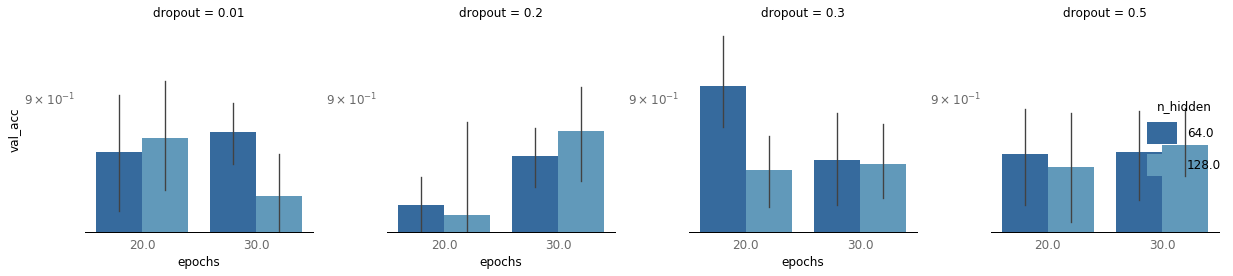

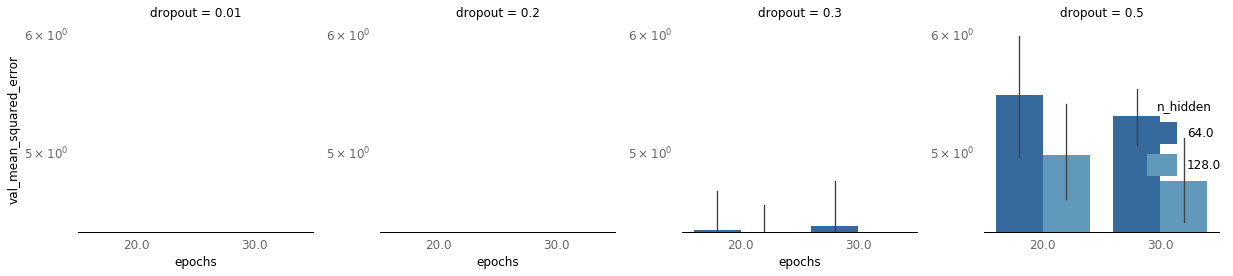

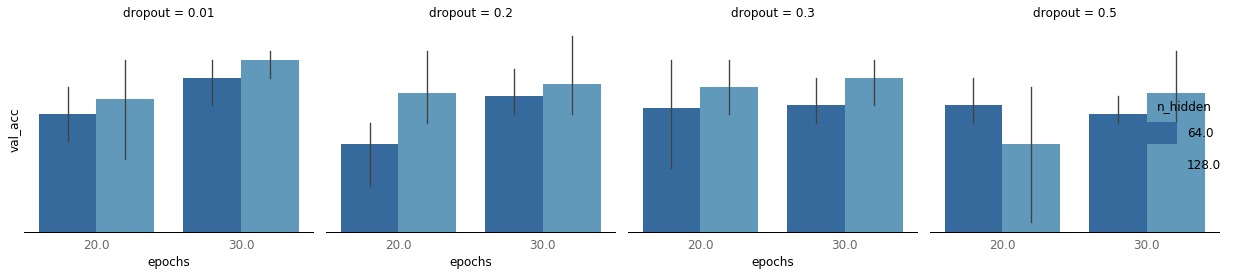

In [117]:
### summarize results.
display(HTML('<H1>main result</H1><br>og acc=%.4f new acc=%.4f' % (og_acc, new_acc)))
for model_name, sort_key in [('baseline', 'val_acc'), ('anchor', 'val_mean_squared_error'), ('final', 'val_acc')]:
    display(HTML('<h2>results for %s model tuning</h2>' % model_name))
    report = ta.Reporting('%s_k_%s.csv'% (model_name, file_suffix), sort_key=sort_key)
    report.plots.bargrid(report.data, x='epochs',y=sort_key, hue='n_hidden', col='dropout', col_wrap=4, y_scale='log')

Some positive but not great results:
    
**og acc=0.6700 new acc=0.7100**
```
np.random.seed(42)
bias_min=.5
bias_max=.6
small_parms = {
    'n_hidden': [64],
    'batch_size': [16],
    'epochs': [10],
    'maxnorm': [10],
    'dropout': [0.1, 0.5]
}

```

**og acc=0.5850 new acc=0.6010**
```
train_bias = .8
test_bias = .2
parms = {
    'n_hidden': [64,128],
    'batch_size': [16,32], 
    'epochs': [20,30],
    'dropout': [0.01,.2,.3,.5],
    'maxnorm': [3,5,10,999],
} 
```

,epochs,dropout
val_acc,,
0.980,20.0,0.2
0.980,30.0,0.0
0.980,30.0,0.5
0.980,30.0,0.0
0.980,10.0,0.5
0.980,10.0,0.2
0.977,30.0,0.2
0.977,10.0,0.3
0.977,30.0,0.0


,epochs,dropout
val_acc,,
0.433,5.0,0.0
0.843,5.0,0.2
0.920,5.0,0.2
0.927,10.0,0.0
0.937,10.0,0.2
0.940,5.0,0.3
0.943,10.0,0.3
0.943,5.0,0.3
0.947,10.0,0.0



 NOTE: you have more options in the Reporting object.



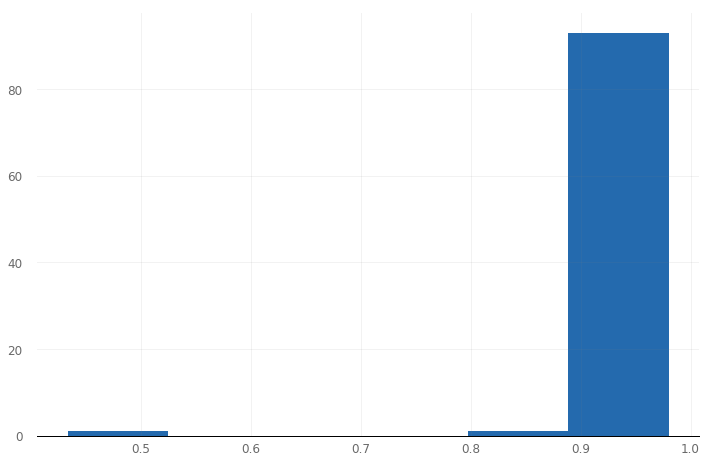

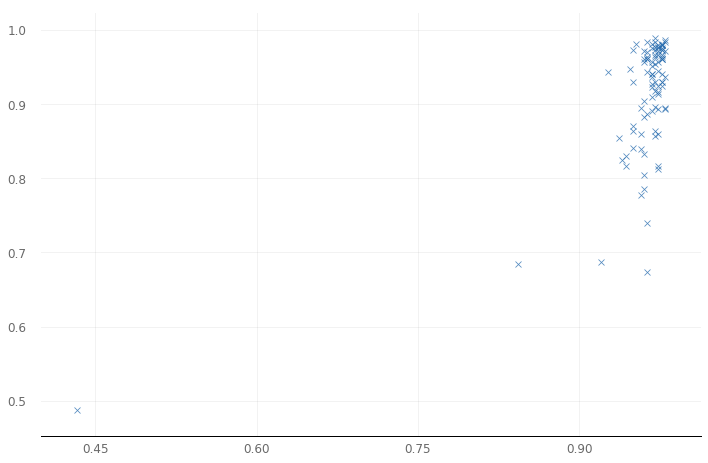

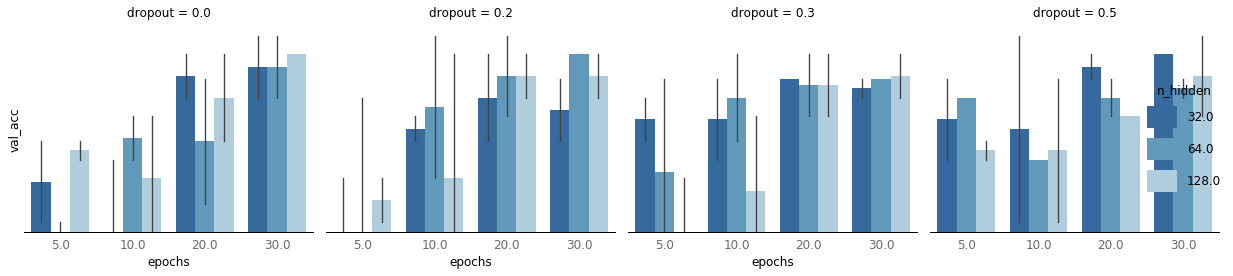

In [ ]:
### abandoned approach:
# method 1: sort clusters by how their cooccurrence changes from train->test
# this does okay, but not great. labels many "good" clusters as unstable,
# presumably because their relationship with the confounds changees from
# train/test
# scores = np.zeros((n_clusters,n_clusters))
# for i, j in it.combinations(np.arange(n_clusters), 2):
#     v = train_test_corr_diff(i, j, X_train_cluster, X_test_cluster)
#     #v = train_test_mi_diff(i, j, X_train_cluster, X_test_cluster)
#     scores[i,j] = scores[j,i] = v
    
# score_sums = scores.sum(axis=0)
# score_medians = [np.median(r) for r in scores]
# print(sorted(enumerate(score_medians), key=lambda x: -x[1]))


# drop worst cluster features and predict.
# this is not a good way to control for a cluster...
# for n_drop in [1,2,3,4,5]:
#     todrop = np.argsort(scores)[::-1][:n_drop]
#     X2 = X_test_cluster.copy()
#     X2[:,todrop] = 0
#     print('dropped %d clusters, acc=%.3f' % 
#           (n_drop, metrics.accuracy_score(clf.predict(X2), biased_test.y)))